In [13]:
from google.colab import drive
drive.mount('/content/drive/')

import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
#from tensorflow.keras.layers import Input
#from tensorflow.keras.models import Model
import tensorflow.keras as keras
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import MeanSquaredError


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
def load_images(folder_path):
    image_list = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            img = cv2.imread(os.path.join(folder_path, filename))
            img = cv2.resize(img, (64,64), interpolation = cv2.INTER_AREA)
            img = img[:,:,::-1]
            img_array = np.array(img) / 255.0
            image_list.append(img_array)
    return np.array(image_list)

folder_path = "/content/drive/Shareddrives/DS340/smd/smd"
x_data = load_images(folder_path)
x_data.shape

(4911, 64, 64, 3)

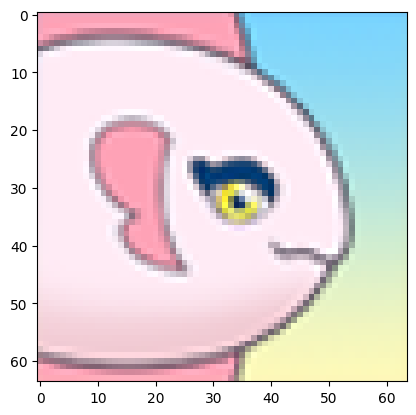

In [6]:
plt.imshow(x_data[9])

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose, Lambda, Flatten
from tensorflow.keras.models import Sequential
import numpy as np

LATENT_DIM = 256  # Dimensionality of the latent space
IMAGE_SIZE = 64

# Encoder
encoder_input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_input)
x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)
x = Flatten()(x)
x = Dense(512, activation="relu")(x)

z_mean_o = Dense(LATENT_DIM, name="z_mean")(x)
z_log_var_o = Dense(LATENT_DIM, name="z_log_var")(x)

# Sampling function
def sampling(args):
    z_mean_o, z_log_var_o = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean_o)[0], LATENT_DIM))
    return z_mean_o + tf.exp(0.5 * z_log_var_o) * epsilon

z1 = Lambda(sampling, output_shape=(LATENT_DIM,), name="z")([z_mean_o, z_log_var_o])

encoder = Model(encoder_input, [z_mean_o, z_log_var_o, z1], name="encoder")

# Decoder
decoder_input = Input(shape=(LATENT_DIM,))
x = Dense(512, activation="relu")(decoder_input)
x = Dense(8 * 8 * 256, activation="relu")(x)
x = Reshape((8, 8, 256))(x)
x = Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_output = Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)

decoder = Model(decoder_input, decoder_output, name="decoder")

# VAE
vae_output = decoder(encoder(encoder_input)[2])
vae = Model(encoder_input, vae_output, name="vae")

print(encoder.summary())
print(decoder.summary())
print(vae.summary())

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 8, 8, 128)    73856       ['conv2d_1[0][0]']               
                                                                                            

In [8]:
# Loss
reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(encoder_input, vae_output))
reconstruction_loss *= IMAGE_SIZE * IMAGE_SIZE
kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var_o - tf.square(z_mean_o) - tf.exp(z_log_var_o), axis=-1)
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)

# Compile
vae.add_loss(vae_loss)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.97)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
vae.compile(optimizer = optimizer)

In [9]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback

class PlotReconstructedImages(Callback):
    def __init__(self, x_val, interval=20):
        super().__init__()
        self.x_val = x_val
        self.interval = interval

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.interval == 0:
            reconstructed_images = self.model.predict(self.x_val)
            self.plot_images(reconstructed_images)

    def plot_images(self, reconstructed_images):
        n = 10
        plt.figure(figsize=(20, 4))

        for i in range(n):
            # Display original images
            ax = plt.subplot(2, n, i + 1)
            plt.imshow(self.x_val[i].reshape(IMAGE_SIZE, IMAGE_SIZE, 3), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # Display reconstructed images
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(reconstructed_images[i].reshape(IMAGE_SIZE, IMAGE_SIZE, 3), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        plt.show()

plot_callback = PlotReconstructedImages(x_data, interval=20)

In [10]:
epochs = 1000
batch_size = 256
vae.fit(x_data, x_data, epochs=epochs, batch_size=batch_size,callbacks=[plot_callback])

Output hidden; open in https://colab.research.google.com to view.

In [11]:
model_path_enco = '/content/drive/MyDrive/DS340_Project/vae_trained_model/fullsmd_enco.h5'
encoder.save(model_path_enco)
model_path_deco = '/content/drive/MyDrive/DS340_Project/vae_trained_model/fullsmd_deco.h5'
decoder.save(model_path_deco)
model_path_vae = '/content/drive/MyDrive/DS340_Project/vae_trained_model/fullsmd_vae.h5'
vae.save(model_path_vae)

In [16]:
from keras.models import load_model
fullsmd_en = load_model(model_path_enco)
fullsmd_de = load_model(model_path_deco)

In [ ]:
folder_path_pk = "/content/drive/MyDrive/DS340_Project/pikachu"
folder_path_jt = "/content/drive/MyDrive/DS340_Project/jennieTurtle"
folder_path_fullsmd = "/content/drive/Shareddrives/DS340/smd/smd"

# need to calculate the average of all zs
avg_z_pk = 0
for i in range(22):
  x_data_pk = load_images(folder_path_pk)[i].reshape(1,64,64,3)
  en_result = fullsmd_en(x_data_pk)
  z = en_result[2]
  avg_z_pk += z
avg_z_pk /= 22
# print(avg_z_pk)

avg_z_jt = 0
for i in range(22):
  x_data_jt = load_images(folder_path_jt)[i].reshape(1,64,64,3)
  en_result = fullsmd_en(x_data_jt)
  z = en_result[2]
  avg_z_jt += z
avg_z_jt /= 22
# print(avg_z_jt)

diff_z = avg_z_pk - avg_z_jt


In [81]:
x_data_origin = x_data[0].reshape(1,64,64,3)
en_result = fullsmd_en(x_data_origin)
z = en_result[2]

z = z - 3.6 * diff_z
re_image = fullsmd_de(z)[1].numpy()
plt.imshow(re_image)
plt.show()

InvalidArgumentError: ignored

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the decoder model
decoder = load_model(model_path)

# Sampling function
def sampling(z_mean, z_log_var):
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], LATENT_DIM), dtype=tf.double)
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Generate a random z_mean and z_log_var for demonstration
z_mean_example = np.random.normal(0, 1, (1, LATENT_DIM))
z_log_var_example = np.random.normal(0, 1, (1, LATENT_DIM))

# Obtain a sample from the latent space
z_sample = sampling(z_mean_example, z_log_var_example)

# Generate an image using the decoder
generated_image = decoder.predict(z_sample)

# Display the generated image
plt.imshow(generated_image[0])
plt.show()

In [ ]:
# putting together

# Encoder
encoder_input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_input)
x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
z_mean = Dense(LATENT_DIM, name="z_mean")(x)
z_log_var = Dense(LATENT_DIM, name="z_log_var")(x)
z = Lambda(sampling, output_shape=(LATENT_DIM,), name="z")([z_mean, z_log_var]) 
#encoder model
encoder = Model(encoder_input, [z_mean, z_log_var, z], name="encoder")


# Decoder
decoder_input = Input(shape=(LATENT_DIM,))
x = Dense(512, activation="relu")(decoder_input)
x = Dense(8 * 8 * 256, activation="relu")(x)
x = Reshape((8, 8, 256))(x)
x = Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_output = Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
#decoder_model
decoder = Model(decoder_input, decoder_output, name="decoder")


# VAE
vae_output = decoder(encoder(encoder_input))
vae_output_two = decoder(encoder_two(encoder_input_two))
vae_output_combined = vae_output + vae_output_two
#vae model
vae = Model(encoder_input, vae_output_combined, name="vae")

# # VAE
# vae_output = decoder(encoder(encoder_input)[2])
# #vae model
# vae = Model(encoder_input, vae_output, name="vae")
# Loss
reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(encoder_input, vae_output))
reconstruction_loss *= IMAGE_SIZE * IMAGE_SIZE
kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
# Compile
vae.add_loss(vae_loss)
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.97)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
vae.compile(optimizer = optimizer)

plot_callback = PlotReconstructedImages(x_data_two, interval=20)

In [ ]:
epochs = 280
batch_size = 2
vae.fit(x_data_one, x_data_one, epochs=epochs, batch_size=batch_size,callbacks=[plot_callback])

In [ ]:
# Multiple Inputs
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import concatenate

folder_path_one = "/content/drive/MyDrive/DS340_Project/jennieTurtle"
x_data_one = load_images(folder_path_one)
folder_path_two = "/content/drive/MyDrive/DS340_Project/pikachu"
x_data_two = load_images(folder_path_two)

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], LATENT_DIM))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

LATENT_DIM = 256  # Dimensionality of the latent space
IMAGE_SIZE = 64

# first Encoder
visible1 = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
x = Conv2D(32, 3, activation="relu", strides=2, padding="same")(visible1)
x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)
x = Flatten()(x)
# second Encoder
visible2 = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
y = Conv2D(32, 3, activation="relu", strides=2, padding="same")(visible2)
y = Conv2D(64, 3, activation="relu", strides=2, padding="same")(y)
y = Conv2D(128, 3, activation="relu", strides=2, padding="same")(y)
y = Conv2D(256, 3, activation="relu", strides=2, padding="same")(y)
y = Flatten()(y)
# merge input models
merge = concatenate([x, y])
# after merge 
after_merge = Dense(512, activation="relu")(merge)
z_mean = Dense(LATENT_DIM, name="z_mean")(after_merge)
z_log_var = Dense(LATENT_DIM, name="z_log_var")(after_merge)
z = Lambda(sampling, output_shape=(LATENT_DIM,), name="z")([z_mean, z_log_var]) 
#encoder model
encoder = Model(inputs=[visible1, visible2], outputs=[z_mean, z_log_var, z], name="encoder")

# Decoder
decoder_input = Input(shape=(LATENT_DIM,))
x = Dense(512, activation="relu")(decoder_input)
x = Dense(8 * 8 * 256, activation="relu")(x)
x = Reshape((8, 8, 256))(x)
x = Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_output = Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
#decoder_model
decoder = Model(decoder_input, decoder_output, name="decoder")

# VAE
vae_output = decoder(encoder([visible1, visible2])[2])
#vae model
vae = Model([visible1, visible2], vae_output, name="vae")
print(encoder.summary(),decoder.summary(),vae.summary())

# Loss
reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy([visible1,visible2], vae_output))
reconstruction_loss *= IMAGE_SIZE * IMAGE_SIZE
kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
# Compile
vae.add_loss(vae_loss)
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.97)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
vae.compile(optimizer = optimizer)
# show img during training
# plot_callback = PlotReconstructedImages([x_data_one, x_data_two], interval=20)
# train start
epochs = 280
batch_size = 10

vae.fit([x_data_one, x_data_two], x_data_two, epochs=epochs, batch_size=batch_size)


In [ ]:
model_path = '/content/drive/MyDrive/DS340_Project/vae_trained_model/merged3.h5'
decoder.save(model_path)

1/1 [==============================] - 0s 128ms/step


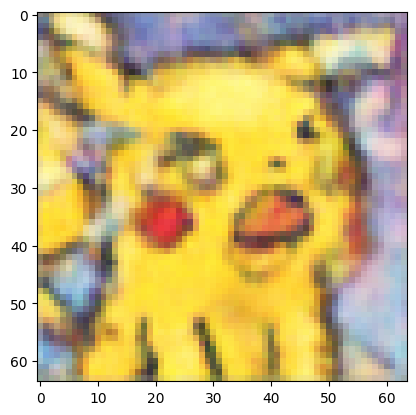

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the decoder model
decoder = load_model(model_path)

# Sampling function
def sampling(z_mean, z_log_var):
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], LATENT_DIM), dtype=tf.double)
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Generate a random z_mean and z_log_var for demonstration
z_mean_example = np.random.normal(0, 1, (1, LATENT_DIM))
z_log_var_example = np.random.normal(0, 1, (1, LATENT_DIM))

# Obtain a sample from the latent space
z_sample = sampling(z_mean_example, z_log_var_example)

# Generate an image using the decoder
generated_image = decoder.predict(z_sample)

# Display the generated image
plt.imshow(generated_image[0])
plt.show()